## Transfer learning with MobileNet V2 for classifying hand poses

Training modern CNNs from scratch requires a lot of labeled training data. However, since I only had 100-200 images per class for this model, I chose to use a technique called transfer learning. Using this techique, I was able to takes a pre-trained network, use it to extract layers, and train a new layer on top for my own task of classifying hand poses. 

Although the model is currently only trained on 2 classes of hand poses, it is possible to introduce new classes in the future. Simply place all the training images for the class into the same folder under the 'archery-data' directory, and tune the hyperparameters such that it is optimised for >2 classes.

In [125]:
import matplotlib.pyplot as plt 
import numpy as np
import PIL.Image as Image

import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory

import shutil, sys, random

In [126]:
print(tf.__version__)

2.4.0


## The 'archery-data' dataset

The 'archery-data' dataset consists of images for 2 classes
* Class data:
 * class 0 (fully drawn): 207 images
 * class 1 (released): 148 images
 
Download the dataset and save it in the current directory/data/archery-data folder. Extract the sub-directories labelled 'fulldrawn' and 'released', and nest them directly under the archery-data director. Directory structure should look like this:
 * data/
  * archery-data/
    * 00/
    * 01/

In [127]:
# Change the DATA_PATH accordingly
DATA_PATH = "data/archery-data"
source_00_dir = os.path.join(DATA_PATH, '00')
source_01_dir = os.path.join(DATA_PATH, '01')

print(len(os.listdir(source_00_dir)))
print(len(os.listdir(source_01_dir)))

# Expected Output:
# 207 
# 148

207
148


### Create a new directory labelled/ that contains the labelled data with the train test split
Directory structure for the labelled data should look like this:
* data/
 * labelled/
   * train/
     * 00/
     * 01/
   * test/
     * 00/
     * 01/

In [108]:
base_dir = 'data/labelled'
training_dir = 'data/labelled/train'
testing_dir = 'data/labelled/test'
train_0_dir = 'data/labelled/train/00'
train_1_dir = 'data/labelled/train/01'
test_0_dir = 'data/labelled/test/00'
test_1_dir = 'data/labelled/test/01'

dir_ls = [base_dir, training_dir, testing_dir,
         train_0_dir, train_1_dir, test_0_dir, test_1_dir]

try:
    for dir_name in dir_ls:
        os.mkdir(dir_name)
except OSError as err:
    print(err)
    pass

In [109]:
"""split_data() 
Method Description
---------
- Copies a random p proportion of images from the source directory
  to the train_dir, and the remapining 1-p proportion to split_dir.
- Checks images before copying, if they have zero file length, they
  will not be copied over. 

Parameters
---------
source   : str, required
    The directory containing the files
train_dir: str, required
    A training directory that a portion of the files will be copied to
test_dir : str, required
    A testing directory that a portion of the files will be copied to
p        : float, required
    The proportion of images to copy to the train directory
"""

def split_data(source, train_dir, test_dir, p):
    item_list = os.listdir(source)
    N = len(item_list) # items in source_dir
    m = N * p # items to be copied to train_dir
    shuffled = random.sample(item_list, len(item_list)) # shuffles item_list in-place
    
    for i in range(N):
        filename = shuffled[i]
        fpath = os.path.join(os.path.abspath(source), filename)
        if os.path.getsize(fpath) > 0:
            if i < m:
                shutil.copy(fpath, train_dir)
            else:
                shutil.copy(fpath, test_dir)
        else:
            continue

print(type(train_0_dir))
            
split_size = .9
split_data(source_00_dir, train_0_dir, test_0_dir, split_size)
split_data(source_01_dir, train_1_dir, test_1_dir, split_size)

<class 'str'>


In [110]:
print(len(os.listdir('data/labelled/train/00')))
print(len(os.listdir('data/labelled/train/01')))
print(len(os.listdir('data/labelled/test/00')))
print(len(os.listdir('data/labelled/test/01')))

# Expected output:
# 187
# 134
# 20
# 14

187
134
20
14


## Download the base model, MobileNet V2

This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, download the base model and use it on a few images from our own dataset to test the accuracy of the model's predictions.

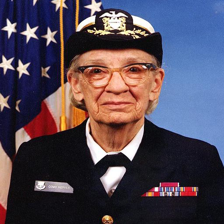

In [146]:
IMAGE_SHAPE = (224, 224) #or (160, 160)
BATCH_SIZE = 32 # or 10

# Download the classifier
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

# Download an image to try it on
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

Shape of original image:(224, 224, 3)


Shape of the result :(1, 1001)
Predicted class :653


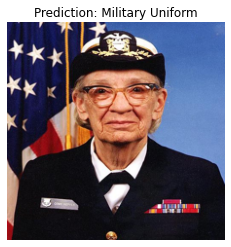

In [120]:
grace_hopper = np.array(grace_hopper)/255.0
print("Shape of original image:" + str(grace_hopper.shape))

# Add a batch dimension, and pass the image to the model
result = classifier.predict(grace_hopper[np.newaxis, ...])
print("Shape of the result :" + str(result.shape))

# Show the top class ID
predicted_class = np.argmax(result[0], axis=-1)
print("Predicted class :" + str(predicted_class))

# Decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [123]:
print(DATA_PATH)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=BATCH_SIZE)

# the labelled dataset has 2 classes
class_names = np.array(train_ds.class_names)
print(class_names)

#Expected: ['00', '01']

data/archery-data
Found 353 files belonging to 2 classes.
Using 283 files for training.
['00' '01']


In [128]:
# Use the Rescaling layer to map the values in the dataframe
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [129]:
# Use buffered prefetching to yield data from disk without having I/O
# become blocking. 
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [130]:
# Run the classifier on the image batch (size: 10)
result_batch = classifier.predict(train_ds)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(predicted_class_names)

['Band Aid' 'Band Aid' 'hammer' 'Band Aid' 'ringneck snake' 'miniskirt'
 'Band Aid' 'Band Aid' 'spider web' 'Band Aid' 'gasmask' 'dumbbell'
 'ski mask' 'ski mask' 'tobacco shop' 'balance beam' 'Band Aid'
 'walking stick' 'remote control' 'Band Aid' 'rule' 'prison' 'Band Aid'
 'cowboy boot' 'dumbbell' 'llama' 'Windsor tie' 'Band Aid' 'jigsaw puzzle'
 'fur coat' 'envelope' 'Band Aid' 'tripod' 'harmonica' 'cocktail shaker'
 'ski mask' 'Band Aid' 'Band Aid' 'syringe' 'joystick' 'ping-pong ball'
 'triceratops' 'Band Aid' 'syringe' 'paintbrush' 'crossword puzzle'
 'pay-phone' 'Band Aid' 'Band Aid' 'Band Aid' 'Band Aid' 'pick' 'Band Aid'
 'safety pin' 'Band Aid' 'dumbbell' 'abaya' 'Band Aid' 'miniskirt'
 'Band Aid' 'envelope' 'Band Aid' 'Band Aid' 'cowboy boot' 'cardigan'
 'Band Aid' 'Band Aid' 'Band Aid' 'Band Aid' 'volleyball' 'syringe'
 'Band Aid' 'Band Aid' 'crossword puzzle' 'Band Aid' 'ski mask'
 'volleyball' 'gasmask' 'suit' 'Band Aid' 'Band Aid' 'Band Aid' 'Band Aid'
 'hand-held compu

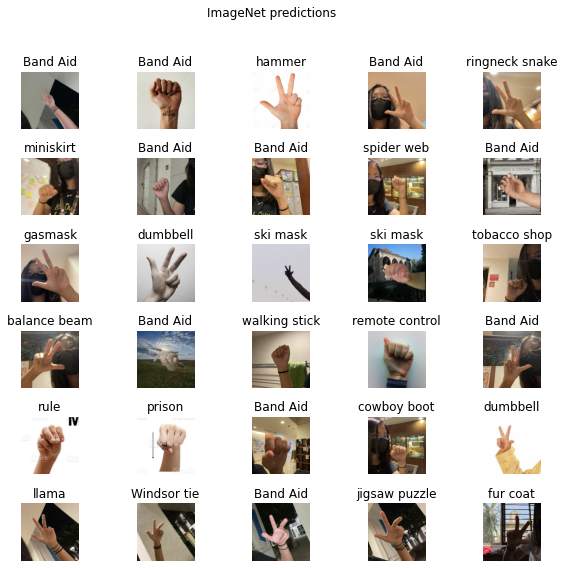

In [131]:
# Check how the predictions line up with the images. 
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Train the top layer of the pre-trained model using the images we have split

In [147]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

In [133]:
# Create the feature extractor, setting trainable=False to freeze the variables
# in the feature extractor layer so that the training only modifies the new classifier
# layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

#It returns a 1280-length vector for each image:

(32, 1280)


In [134]:
# Attach a classification head by wrapping the hub layer in a tf.keras.Sequential
# model, and add a new classification 

num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [135]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 2])

In [136]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [137]:
# Use the .fit method to train the model

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=20,
                    callbacks=[batch_stats_callback])

Epoch 1/20
9/9 [==============================] - 8s 668ms/step - loss: 0.4761 - acc: 0.7727
Epoch 2/20
9/9 [==============================] - 9s 949ms/step - loss: 0.2406 - acc: 0.9250
Epoch 3/20
9/9 [==============================] - 8s 839ms/step - loss: 0.1498 - acc: 0.9656
Epoch 4/20
9/9 [==============================] - 7s 736ms/step - loss: 0.1049 - acc: 0.9875
Epoch 5/20
9/9 [==============================] - 7s 781ms/step - loss: 0.0792 - acc: 0.9906
Epoch 6/20
9/9 [==============================] - 7s 798ms/step - loss: 0.0633 - acc: 0.9969
Epoch 7/20
9/9 [==============================] - 6s 697ms/step - loss: 0.0523 - acc: 1.0000
Epoch 8/20
9/9 [==============================] - 7s 742ms/step - loss: 0.0444 - acc: 1.0000
Epoch 9/20
9/9 [==============================] - 6s 704ms/step - loss: 0.0384 - acc: 1.0000
Epoch 10/20
9/9 [==============================] - 6s 661ms/step - loss: 0.0337 - acc: 1.0000
Epoch 11/20
9/9 [==============================] - 7s 809ms/step - lo

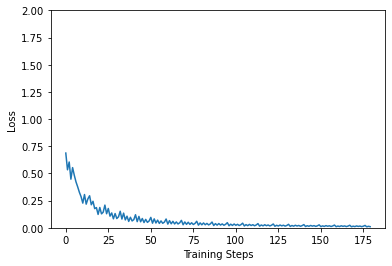

In [138]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

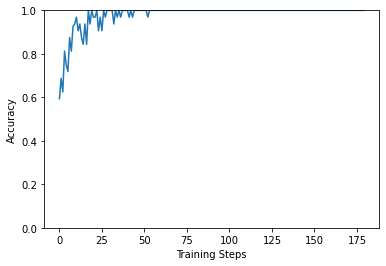

In [139]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [140]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

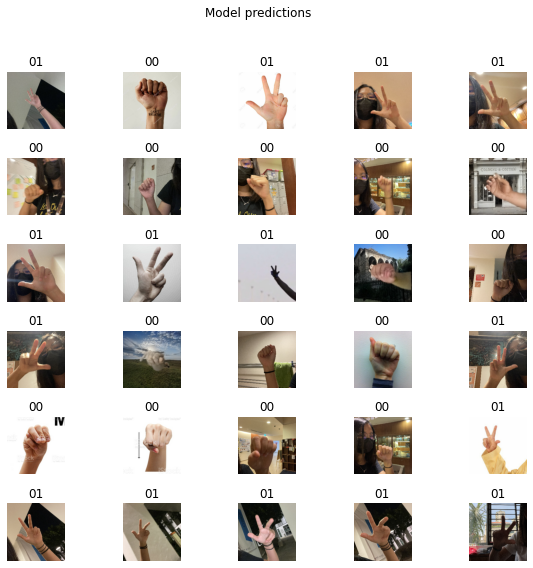

In [141]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export the model

Save the model as a SavedModel under a directory called 'data/saved_models', with the filename being the integer representing the current time. 

In [142]:
import time

t = time.time()

# Change the export path accordingly
export_path = "data/saved_models/{}".format(int(t))
model.save(export_path)

print('Export path : ' + export_path)

INFO:tensorflow:Assets written to: data/saved_models/1622981079/assets


INFO:tensorflow:Assets written to: data/saved_models/1622981079/assets


Export path : data/saved_models/1622981079


In [143]:
reloaded = tf.keras.models.load_model(export_path)

In [144]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [145]:
abs(reloaded_result_batch - result_batch).max()

0.0